In [1]:
using DifferentialEquations
using DifferentialEquations.EnsembleAnalysis
using StatsBase, DataFrames
using Parameters, Plots, BenchmarkTools

### Jump Problem Setup

In [3]:
# L11-23 from src/single_jump_instead_of_many.jl
function affect!(integrator)
  n = rand(1:integrator.p.N)
  n2 = rand(1:integrator.p.N)
  integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end

function μ_SDE(du,u,p,t)
  du .= p.μ
end

function σ_SDE(du,u,p,t)
  du .= p.σ
end

σ_SDE (generic function with 1 method)

In [2]:
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # saveat
    moments = Array{Array{Float64, 1}, 1}())

p = params()

(μ = 0.01, σ = 0.1, N = 10, β = 0.2, t = 0.0:0.01:10.0, moments = Array{Float64,1}[])

In [4]:
x_iv = rand(p.N)  # just draws from the inital condition

prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, p.t[end]), p)
rate(u,p,t) = p.β*p.N
jump = ConstantRateJump(rate,affect!)
jump_prob = JumpProblem(prob,Direct(),jump)

JumpProblem with problem SDEProblem and aggregator Direct
Number of constant rate jumps: 1
Number of variable rate jumps: 0


### Callback Setup

In [5]:
function save_func(u, t, integrator) 
    if length(integrator.p.moments) == 0 
        g = 0.
    else
        g = mean(u) - integrator.p.moments[end][2]
    end            
    moments = [minimum(u), mean(u), maximum(u), g]
    push!(integrator.p.moments, moments) 
end

save_func (generic function with 1 method)

In [6]:
cb = FunctionCallingCallback(save_func;
                 funcat=p.t,
                 func_everystep=false,
                 func_start = true,
                 tdir=1)

DiscreteCallback{getfield(DiffEqCallbacks, Symbol("##25#26")),DiffEqCallbacks.FunctionCallingAffect{typeof(save_func),DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Array{Float64,1}},typeof(DiffEqCallbacks.functioncalling_initialize)}(getfield(DiffEqCallbacks, Symbol("##25#26"))(), DiffEqCallbacks.FunctionCallingAffect{typeof(save_func),DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Array{Float64,1}}(save_func, DataStructures.BinaryHeap{Float64,DataStructures.LessThan}(DataStructures.LessThan(), [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.0]), [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.0], false, true, 0), DiffEqCallbacks.functioncalling_initialize, Bool[false, false])

### Ensemble Setup

In [7]:
function output_func(sol, i)
    resize!(sol.t, 0)
    resize!(sol.u, 0)
    append!(sol.t, sol.prob.p.t) # or something like that... need the `t` values we used for the moments
    append!(sol.u, sol.prob.p.moments)
    return (sol, false)
end

output_func (generic function with 1 method)

In [8]:
ensemble_prob = EnsembleProblem(prob, output_func = output_func)

EnsembleProblem with problem SDEProblem

### Solve and Plot

In [9]:
sim = solve(ensemble_prob, SRIW1(), EnsembleSerial(), trajectories = 2, callback = cb, save_everystep = false)

EnsembleSolution Solution of length 2 with uType:
RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,DataStructures.Stack{Tuple{Float64,Array{Float64,1},Array{Float64,1}}},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{:RSwM3,Float64},RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,NamedTuple{(:μ, :σ, :N, :β, :t, :moments),Tuple{Float64,Float64,Int64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Array{Float64,1},1}}},Nothing,SDEFunction{true,typeof(μ_SDE),typeof(σ_SDE),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(σ_SDE),Nothing,Nothing},SR

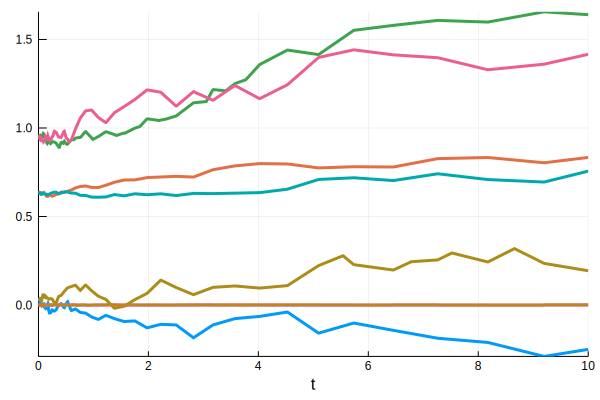

In [10]:
plot(sim)

In [11]:
summ = EnsembleSummary(sim)

EnsembleSolution Solution of length 1001 with uType:
Float64

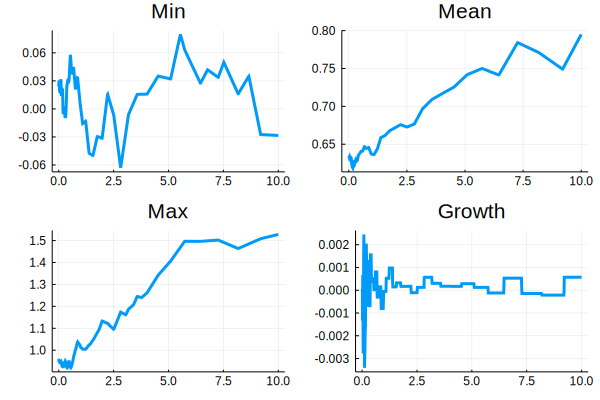

In [14]:
p1 = plot(summ, idxs = [1], error_style = :none, title = "Min")
p2 = plot(summ, idxs = [2], error_style = :none, title = "Mean")
p3 = plot(summ, idxs = [3], error_style = :none, title = "Max")
p4 = plot(summ, idxs = [4], error_style = :none, title = "Growth")

plot(p1, p2, p3, p4)